In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from GProtation import make_plot, lnprob
from Kepler_ACF import corr_run
import h5py
from gatspy.periodic import LombScargle
import sys
import os
import time
import emcee
import pyfits

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
DATA_DIR = "data/"
RESULTS_DIR = "results/"

In [3]:
def load_data(epic_id, DATA_DIR):
    hdulist = pyfits.open(os.path.join(DATA_DIR, "hlsp_everest_k2_llc_{0}-c04_kepler_v1.0_lc.fits".format(epic_id)))
    time, flux = hdulist[1].data["TIME"], hdulist[1].data["FLUX"]
    out = hdulist[1].data["OUTLIER"]
    m = np.isfinite(time) * np.isfinite(flux) * (out < 1)
    med = np.median(flux[m])
    return time[m], flux[m]/med - 1

Load first target.

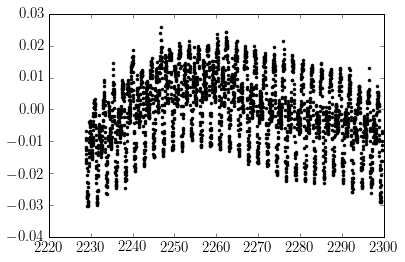

In [4]:
#epic_id = 211000411
epic_id = 211098454
x, y = load_data(epic_id, DATA_DIR)
yerr = np.ones_like(y) * 1e-5
plt.plot(x, y, "k.")

Calculate ACF using McQuillan (2013) code

Calculating ACF...
Calculating errors and asymmetries...


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:1810: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  c = c[Nx - 1 - maxlags:Nx + maxlags]


1/2 P found (1st)
10 Peaks kept
>>>>>>>>>> [-0.00510841 -0.01532524 -0.01532524  0.00510841  0.02554206  0.00510841
  0.02554206  0.00510841 -0.01532524 -0.01532524]
0.0227273272125
0.0075757757375
calculating var for P_med...
saving figure results//211098454_full.png
PERIOD =  2.094449125 +/- 0.0075757757375
saving as results//211098454_result.txt
acf period, err =  [ 2.09444913] [ 0.00757578]


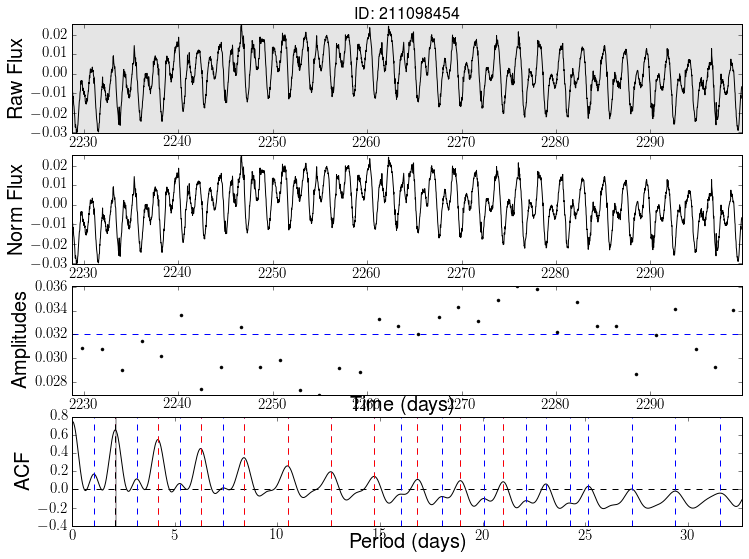

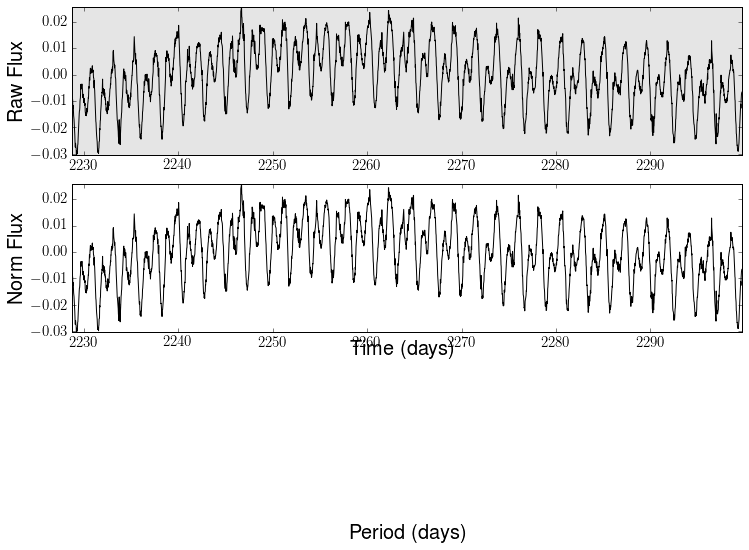

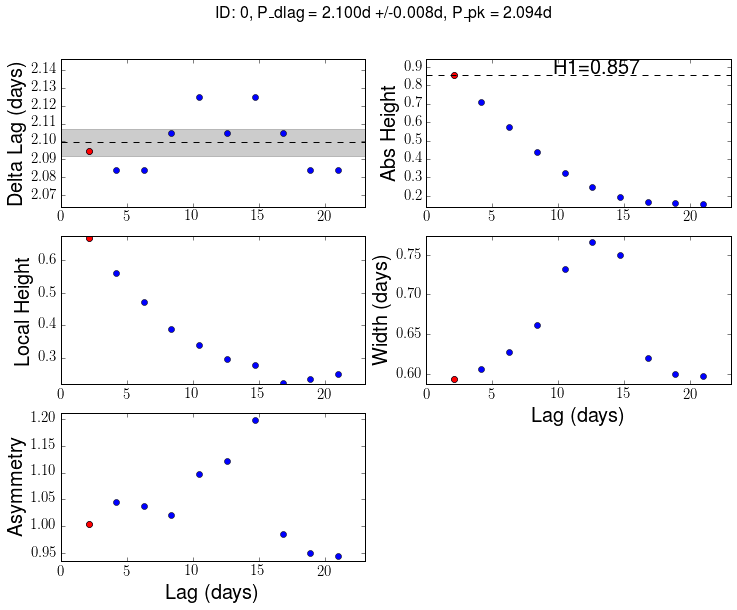

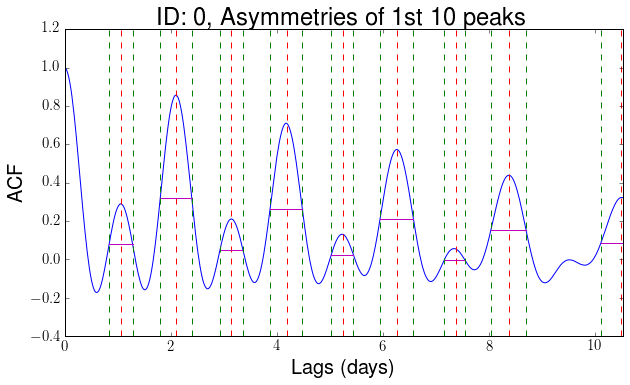

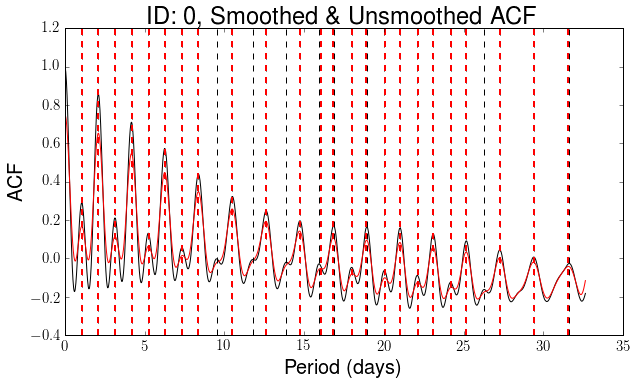

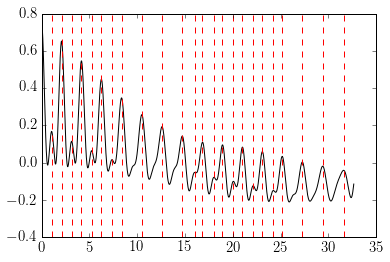

In [6]:
fname = os.path.join(RESULTS_DIR, "{0}_acf_result.txt".format(epic_id))
p_init, err, lags, acf = corr_run(x, y, yerr, epic_id, RESULTS_DIR)
np.savetxt(os.path.join(RESULTS_DIR, "{0}_acf_result.txt".format(epic_id)), np.array([p_init[0], err[0]]).T)
print("acf period, err = ", p_init, err)
plt.plot(lags, acf)

Calculate periodogram

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


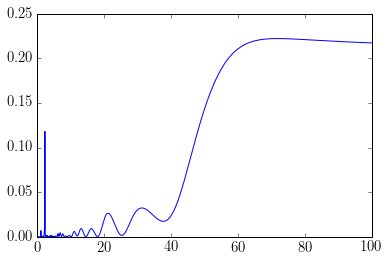

In [7]:
ps = np.arange(.1, 100, .1)
print(type(x), type(y), type(yerr))
model = LombScargle().fit(x, y, yerr)
pgram = model.periodogram(ps)
plt.plot(ps, pgram)

Prep MCMC and set limits on prior.

In [8]:
plims = np.log([.8*p_init, 1.2*p_init])
print("total number of points = ", len(x))
theta_init = np.log([np.exp(-5), np.exp(7), np.exp(.6), np.exp(-16), p_init])
burnin, nwalkers = 10, 12
runs = np.zeros(10) + 100
ndim = len(theta_init)
p0 = [theta_init+1e-4*np.random.rand(ndim) for i in range(nwalkers)]
args = (x, y, yerr, plims)

total number of points =  3197


Time the LHF call.

In [9]:
start = time.time()
print("lnprob = ", lnprob(theta_init, x, y, yerr, plims))
end = time.time()
tm = end - start
print("1 lhf call takes ", tm, "seconds")
print("burn in will take", tm * nwalkers * burnin, "s")
print("each run will take", tm * nwalkers * runs[0], "s")
print("total = ", (tm * nwalkers * runs[0] + tm * nwalkers * burnin)/60, "mins")

lnprob =  -379606.953798
1 lhf call takes  0.6474330425262451 seconds
burn in will take 77.69196510314941 s
each run will take 776.919651031 s
total =  14.2435269356 mins


Run MCMC.

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
print("burning in...")
p0, _, state = sampler.run_mcmc(p0, burnin)

for run in runs:
    sampler.reset()
    print("production run, {0} steps".format(run))
    start = time.time()
    p0, _, state = sampler.run_mcmc(p0, run)
    end = time.time()
    print("time taken = ", (end - start)/60, "minutes")
    
    # save samples
    f = h5py.File(os.path.join(RESULTS_DIR, "{0}.h5".format(epic_id)), "w")
    data = f.create_dataset("samples", np.shape(sampler.chain))
    data[:, :] = np.array(sampler.chain)
    f.close()
    
    # make various plots
    with h5py.File(os.path.join(RESULTS_DIR, "{0}.h5".format(epic_id)), "r") as f:
        samples = f["samples"][...]
    mcmc_result = make_plot(samples, x, y, yerr, epic_id, RESULTS_DIR, traces=True, tri=True, prediction=True)

burning in...


Save samples.

Make various plots.


 2.24900198389 period (days) 

[ -4.99992156   6.99940157   0.64300635 -15.87719154   0.81048656]
Plotting traces
Making triangle plot
results//test_triangle.png
plotting prediction
results//test_prediction.png


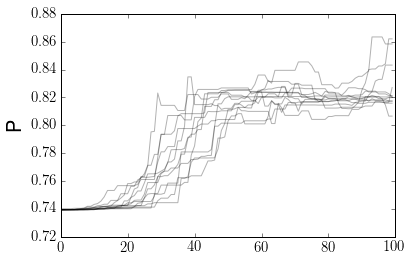

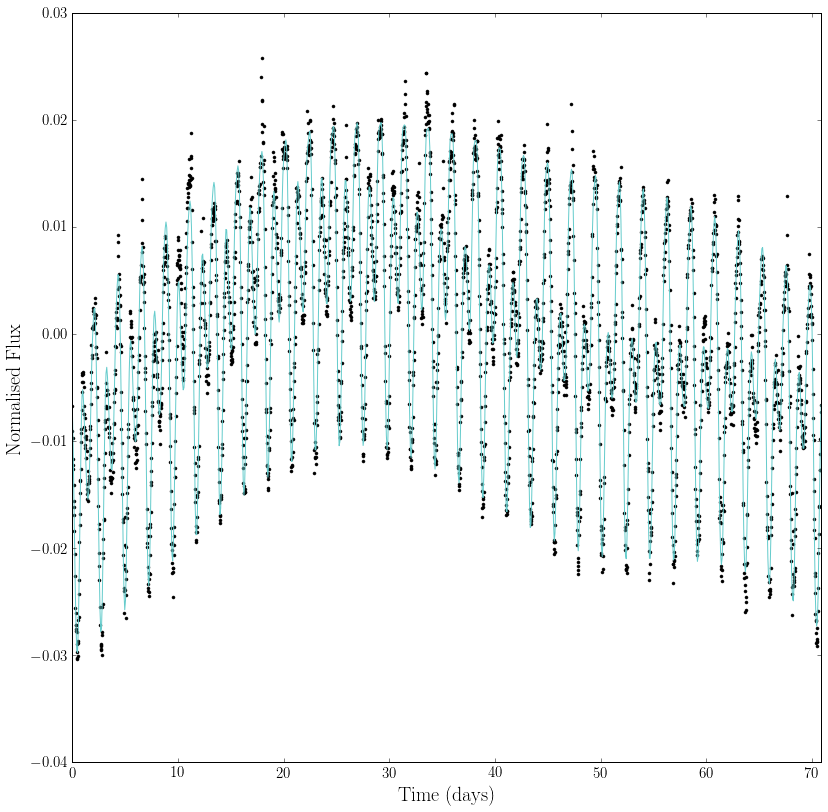

production run 2...
actual time =  9.746266933282216 minutes

 2.26783777205 period (days) 

[ -9.12032223   2.57158899   0.2190663  -13.99547386   0.81882685]
Plotting traces
Making triangle plot
results//test_triangle.png
plotting prediction
results//test_prediction.png


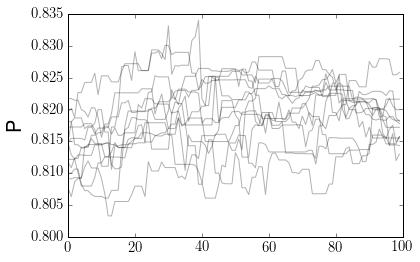

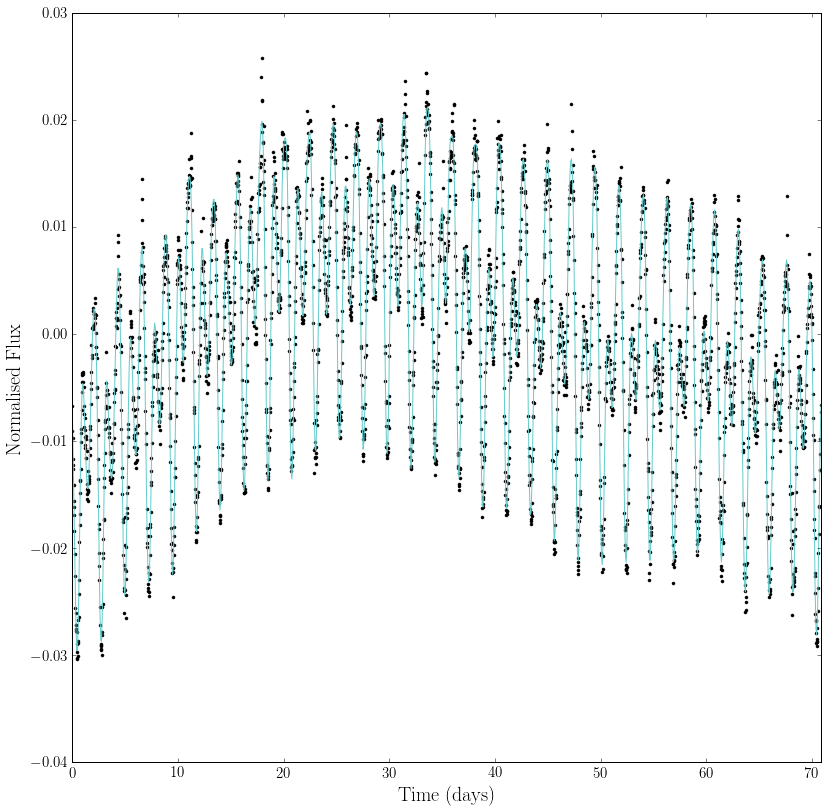

In [31]:
start = time.time()
print("production run 2...")
sampler.reset()
p0, _, state = sampler.run_mcmc(p0, run)
end = time.time()
print("actual time = ", (end - start)/60, "minutes")
f = h5py.File(os.path.join(RESULTS_DIR, "{0}_test.h5".format(epic_id)), "w")
data = f.create_dataset("samples", np.shape(sampler.chain))
data[:, :] = np.array(sampler.chain)
f.close()
with h5py.File(os.path.join(RESULTS_DIR, "{0}_test.h5".format(epic_id)), "r") as f:
    samples = f["samples"][...]
mcmc_result = make_plot(samples, x, y, yerr, "test", RESULTS_DIR, traces=True, tri=True, prediction=True)

In [ ]:
start = time.time()
print("production run 3...")
sampler.reset()
p0, _, state = sampler.run_mcmc(p0, run)
end = time.time()
print("actual time = ", (end - start)/60, "minutes")
f = h5py.File(os.path.join(RESULTS_DIR, "{0}_test.h5".format(epic_id)), "w")
data = f.create_dataset("samples", np.shape(sampler.chain))
data[:, :] = np.array(sampler.chain)
f.close()
with h5py.File(os.path.join(RESULTS_DIR, "{0}_test.h5".format(epic_id)), "r") as f:
    samples = f["samples"][...]
mcmc_result = make_plot(samples, x, y, yerr, "test", RESULTS_DIR, traces=True, tri=True, prediction=True)

production run 3...


In [ ]:
run = 500
start = time.time()
print("production run 3...")
sampler.reset()
p0, _, state = sampler.run_mcmc(p0, run)
end = time.time()
print("actual time = ", (end - start)/60, "minutes")
f = h5py.File(os.path.join(RESULTS_DIR, "{0}_test.h5".format(epic_id)), "w")
data = f.create_dataset("samples", np.shape(sampler.chain))
data[:, :] = np.array(sampler.chain)
f.close()
with h5py.File(os.path.join(RESULTS_DIR, "{0}_test.h5".format(epic_id)), "r") as f:
    samples = f["samples"][...]
mcmc_result = make_plot(samples, x, y, yerr, "test", RESULTS_DIR, traces=True, tri=True, prediction=True)